# Introduction

* The capacity of intelligent systems, such as fuzzy logic or genetic algorithms, to adapt to changes seems suitable for these type of problems. Many fuzzy logic approaches for self tuning were proposed, where fuzzy rules where applied to obtain the PID parameters to control different types of plants. 
* The progress was expanded by the development of a number of policy function and actor-critic algorithms which allow the RL agent to selec contionuous values for the control actions in order to solve complex continuous control tasks. 

* In this work, we propose a model-free goal-driven deep RL method, based on the DDGP algorithm, for self tuning of the low-level PID controllers of mobine robots. 
* The proposed hybrid control strategy uses an actor-critic strucuture and it only receives low-level dyamic information as input and simultaneously estimates the multiple parameters or gains for the MIMO PID control system. 
* Recently, the deep deterministic policy gradient (DDPG) algorithm was developed, which is an actor-critic RL algorithm that uses a state-action value function Q(x,k) as critic and a deterministic action selection function $\pi$ for the actor. 
* The critic (Q function gives information about the quality of the action k taken at state x)
* The DDPG algorithm avoids this global optimization by moving the policy towards the gradient of the Q function. The main causes of the lack of convergence were the correlation of the samples used for the training and the correlation between updates of the Q network. 

* The idea behind this work is the introduction of value functions that generalized not only over states x but also over goals g. 

# Adaptive deep RL formulation for low-level MIMO-PID control

* In the proposed architecture, the RL agent only selects an action $k_t$ the parameters of the PID controllers, every T sampling time steps dt. By having such a structure, it is possible for the PID controllers to adapt to unknown environment changes. 

* The advantage of working with a state vector for the RL agent defined in that way is that it gives more information of the dynamics of the system. 

* This way, by enahcing the description of the state we aim to increase the agent's ability to adapt to goal changes. 

* For example, when an obstacle is detected by an obstacle avoidance module in order to avoid this obstacle, the supervisor orders a turn manueruver by sending a new request for the angular velocity to the low-level control system.
* Therefore, the goal of the control system changes. In summary, this is the type of in-episode varying goals that we considered for the work => The idea can be generalized to different decision-making systems of other technological systems that implement several close-loop PID controllesr like in continuous process industry. 

* Usually, for continuous actions the actor uses a hyperbolic tangent function as output (tanh()) such that the output is bounded to the interval -1 to +1. 

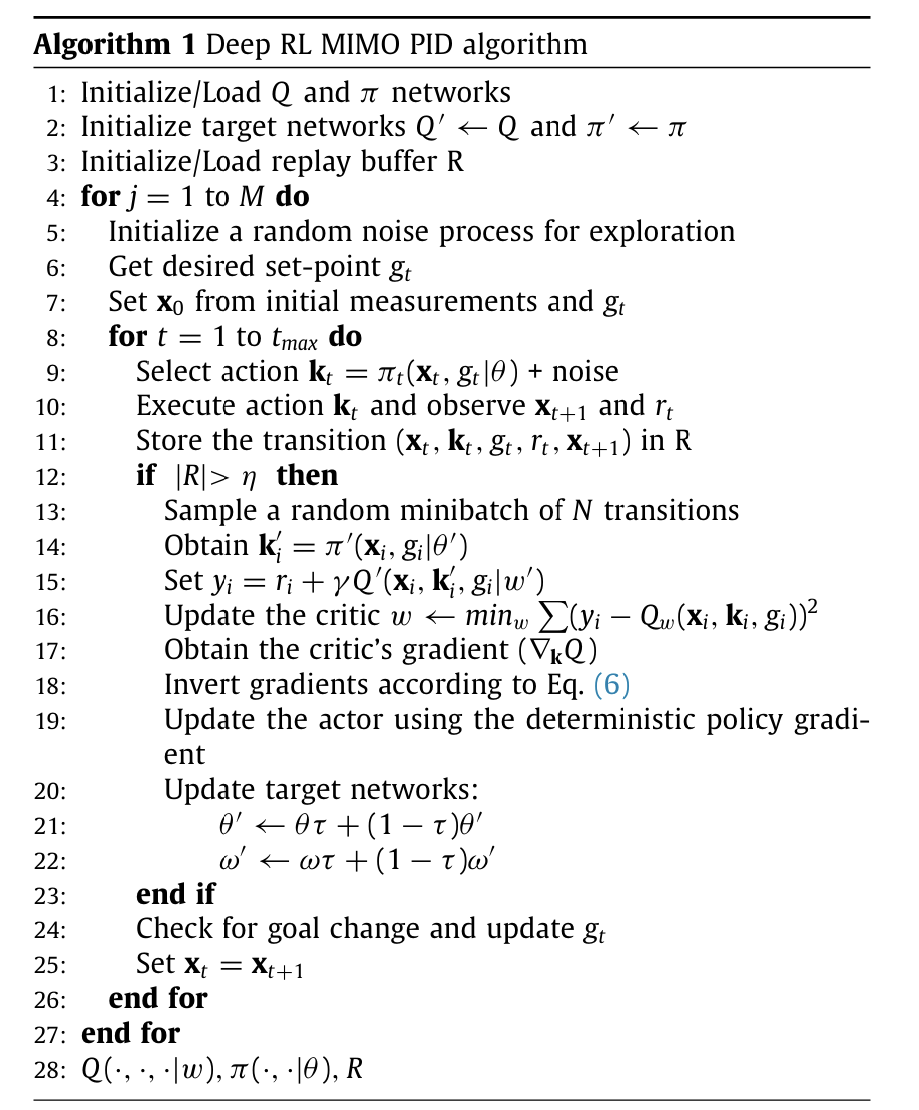

In [ ]:
# pid.py

import numpy as np

class pid_controller():
    def __init__(self, set_point, n_actions=6, dt=0.1):
        self.dt=dt
        self.actions=n_actions
        self.set_point=set_point
        self.action_vx=np.zeros(3)
        self.action_wz=np.zeros(3)
        self.u=np.zeros(6)
        self.u0=np.zeros(6)
        self.error=np.zeros((3,2))

    def update_action(self, actions):
        self.action_vx=actions[0:3] # PIDs [0:2]
        self.action_wz=actions[3:6] # PIDs [2:4]
        return

    def update(self, velocity):
        self.velocity=velocity
        self.error[2] = self.error[1]
        self.error[1] = self.error[0]
        self.error[0][0] = self.set_point[0] - self.velocity[0] # vx
        self.error[0][1] = self.set_point[5] - self.velocity[5] # wz

        self.u[0] = self.controller_pid(self.error[0][0], self.error[1][0], self.error[2][0], self.action_vx, self.u0[0])
        self.u[1] = self.controller_pid(self.error[0][1], self.error[1][1], self.error[2][1], self.action_wz, self.u0[1])
        self.u = np.clip(self.u, -0.8, 0.8)
        self.u0[0] = self.u[0]
        self.u0[1] = self.u[1]
        return self.u

    def controller_pid(self, et, et1, et2, action, u0):
        Kp = action[0]
        Ti = action[1]
        Td = action[2]

        k1 = Kp*(1 + self.dt/Ti + Td/self.dt)
        k2 =-Kp*(1+2*Td/self.dt)
        k3 = Kp*(Td/self.dt)

        u = u0 + k1*et + k2*et1 + k3*et2
        return u
    
    def reset(self):
        self.action_vx = np.zeros(3)
        self.action_wz = np.zeros(3)
        self.u = np.zeros(6)
        self.u0 = np.zeros(6)
        self.error = np.zeros((3,2))
        return


    class pi_controller():
        def __init__(self, set_point, n_actions=6, dt=0.1):
            self.dt = dt
            self.actions = n_actions
            self.set_point = set_point
            self.action_vx = np.zeros(3)
            self.action_wz = np.zeros(3)
            self.u = np.zeros(6)
            self.u0 = np.zeros(6)
            self.error = np.zeros((3, 2))

        def update_action(self, actions):
            self.action_vx = actions[0:2]
            self.action_wz = actions[2:4]

            return
    
        def update(self, velocity):
            self.velocity = velocity
            self.error[2] = self.error[1]
            self.error[1] = self.error[0]  
            self.error[0][0] = self.set_point[0] - self.velocity[0] # vx
            self.error[0][1] = self.set_point[5] - self.velocity[5] # wz

            self.u[0] = self.controller_pi(self.error[0][0], self.error[1][0], self.error[2][0], self.action_vx, self.u0[0]) 
            self.u[1] = self.controller_pi(self.error[0][1], self.error[1][1], self.error[2][1], self.action_wz, self.u0[1]) 
            self.u = np.clip(self.u, -0.8, 0.8)
            self.u0[0] = self.u[0]
            self.u0[1] = self.u[1]

            return self.u

        def controller_pi(self, et, et1, et2, action, u0):
            Kp = action[0]
            Ti = action[1]
            Td = 0.

            k1 = Kp*(1+Td/self.dt)
            k2 =-Kp*(1+2*Td/self.dt-self.dt/Ti)
            k3 = Kp*(Td/Ti)

            u = u0 + k1*et + k2*et1 + k3*et2
        
            return u
        
        def reset(self):
            self.action_vx= np.zeros(3)
            self.action_wz= np.zeros(3)
            self.u= np.zeros(6)
            self.u0= np.zeros(6)
            self.error= np.zeros((3,2))
            return
    
    


In [ ]:
import tensorflow as tf
import numpt as np
import gymnasium as gym
from ou_noise import OUNoise

class IDDPG(object):
    def __init__(self, sess, state_dim, action_dim, max_action, min_action, actor_learning_rate, critic_learning_rate, tau, RANDOM_SEED, device = '/cpu:0'):
        self.sess = sess
        np.random.seed(RANDOM_SEED)
        tf.set_random_seed(RANDOM_SEED)
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.tau = tau
        self.device = device
        self.max_action = max_action
        self.min_action = min_action
        self.inputs = tf.placeholder(tf.float32, shape=[None, self.s_dim], name='state')
        self.action = tf.placeholder(tf.float32, shape=[None, self.a_dim], name='action')
        scope = 'net'

        with tf.variable_scope('learning_rate'):
            self.global_step = tf.Variable(0, trainable=False)
            self.actor_decay_learning_rate = tf.train.exponential_decay(self.actor_learning_rate, self.global_step, 10000, 0.96, staircase=True)
            self.critic_decay_learning_rate = tf.train.exponential_decay(self.critic_learning_rate, self.global_step, 10000, 0.96, staircase=True)
        with tf.device(self.device):
            self.generate_param_updater()
            self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])
            self.squared = tf.square(tf.subtract(self.predicted_q_value, self.v))
            self.l2_loss = tf.reduce_mean(self.squared) + self.l2_loss
            self.critic_optimize = tf.train.adamoptimizer(self.critic_decay_learning_rate).minimize(self.l2_loss, global_step=self.global_step)
            self.action_grads = tf.gradients(self.v, self.action)[0]
            self.actor_gradients = tf.gradients(self.a, self.a_params, -self.action_grads)
            self.actor_optimize = tf.train.AdamOptimizer(self.actor_decay_learning_rate).apply_gradients(zip(self.actor_gradients, self.a_params), global_step=self.global_step)

            # invert gradients
            self.inverting_gradients_placeholder = tf.placeholder(tf.float32, shape=[None, self.a_dim], name='inverting_gradients')
            self._dq_da = tf.gradients(self.v, self.action)[0]
            self._grad = tf.gradients(self.a, self.a_params, -self.inverting_gradients_placeholder)
            self._train_actor = tf.train_AdamOptimizer(self.actor_decay_learning_rate).apply_gradients(zip(self._grad, self.a_params), global_step=self.global_step)

        def _build_net(self,scope):
       
            with tf.device(self.device):        
                with tf.variable_scope(scope + '/critic'):
                    
                    
                    '''
                    net = tf.layers.dense(self.inputs, LAYER_1, tf.nn.relu, name='critic_L1')
                    initializer = tf.variance_scaling_initializer()
                    s_union_weights = tf.Variable(initializer.__call__([LAYER_1, LAYER_2]), name='critic_L2_Ws')
                    a_union_weights = tf.Variable(initializer.__call__([self.a_dim, LAYER_2]), name='critic_L2_Wa')
                    union_biases = tf.Variable(tf.zeros([LAYER_2]), name='critic_L2_b')
                    net = tf.nn.relu(tf.matmul(net, s_union_weights) + tf.matmul(self.action, a_union_weights) + union_biases,name='critic_L2')
                    w_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
                    v = tf.layers.dense(net, self.a_dim, kernel_initializer=w_init, name='critic_output')
                    '''
                    regularizer = tf.contrib.layers.l2_regularizer(scale=LAMBDA)
                    l1 = tf.contrib.layers.fully_connected(self.inputs, LAYER_1, weights_regularizer=regularizer, activation_fn=tf.nn.leaky_relu)
                    l2_a = tf.contrib.layers.fully_connected(self.action, LAYER_2, weights_regularizer=regularizer, activation_fn=None)
                    l2_s = tf.contrib.layers.fully_connected(l1, LAYER_2, weights_regularizer=regularizer,activation_fn=None)
                    l2 = tf.nn.leaky_relu(l2_s + l2_a)
                    v = tf.contrib.layers.fully_connected(l2, 1, weights_regularizer=regularizer, activation_fn=None)
                    
                with tf.variable_scope(scope + '/actor'):
                    l1 = tf.contrib.layers.fully_connected(self.inputs, LAYER_1,  activation_fn=tf.nn.leaky_relu) # tf.nn.leaky_relu tf.nn.relu
                    l2 = tf.contrib.layers.fully_connected(l1, LAYER_2,  activation_fn=tf.nn.leaky_relu)
                    w_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
                    a = tf.contrib.layers.fully_connected(l2, self.a_dim, weights_initializer=w_init, activation_fn=None) # None  tf.nn.tanh
                    scaled_a = a
                    # scaled_a = tf.clip_by_value(a,self.min_action,self.max_action)#tf.multiply(a, self.action_bound)
                        
            saver = tf.train.Saver()
            return v, a, scaled_a, saver